In [1]:
%matplotlib inline

import os

from matplotlib import pyplot as plt
import pandas as pd

from getpass import getpass
from sqlalchemy import create_engine

from epana import tabular

oracle_connection_string = 'oracle+cx_oracle://' + \
    '{username}:{password}@{hostname}:{port}/{database}'


engine = create_engine(
    oracle_connection_string.format(
        username=input('User: '),
        password=getpass('Password: '),
        hostname='hssc-cdwr3-dtdb-p',
        port='1521',
        database='dtprd2'
    ),
    arraysize=50000
)

def q(sql, engine):
    return tabular.df_from_sql(sql, engine)

User: ephelps
Password: ········


In [2]:
sql_pat_states = '''
select /*+ parallel 4 */
    enc.datasource_id,
    enc.patient_id,
    dx.dx_code,
    trunc(enc.visit_start_date, 'month') enc_month,
    count(distinct enc.visit_id) n_encs
from cdw.diagnosis dx
inner join cdw.visit enc
  on ( dx.visit_id = enc.visit_id )
where (   (    dx_code like 'C50%' )
       or (    dx_code like 'C34.0%'
            or dx_code like 'C34.1%'
            or dx_code like 'C34.2%'
            or dx_code like 'C34.3%'
            or dx_code like 'C34.8%'
            or dx_code like 'C34.9%'
          )
       or (    dx_code like 'C92%'
          )
       or (    dx_code like 'C18%'
            or dx_code like 'C19.9%'
          )
       or (    dx_code like 'C44.2%'
            or dx_code like 'C44.4%'
            or dx_code like 'C44.5%'
            or dx_code like 'C44.6%'
            or dx_code like 'C44.7%'
            or dx_code like 'C44.9%'
          )
       or (    dx_code like 'G35%'
          )
       or (    dx_code like 'M05%'
            or dx_code like 'M06%'
            or dx_code like 'M08.0%'
            or dx_code like 'M08.1%'
            or dx_code like 'M08.2%'
            or dx_code like 'M08.3%'
            or dx_code like 'M08.4%'
          )
      )
group by 
    enc.datasource_id,
    enc.patient_id,
    dx.dx_code,
    trunc(enc.visit_start_date, 'month')
'''

In [3]:
%time df_pat_states = q(sql_pat_states, engine)

CPU times: user 747 ms, sys: 76 ms, total: 823 ms
Wall time: 17.7 s


In [4]:
df_pat_states.head()

datasource_id  patient_id  dx_code  enc_month  n_encs
0             25  46426528.0   C44.41 2019-02-01       1
1             25  44995792.0  M05.742 2018-04-01       1
2             14  45034757.0  C50.212 2015-12-01       2
3             25  45416425.0  C50.919 2016-02-01       3
4             25  42278840.0      G35 2018-05-01       2

In [5]:
df_pat_states_summary = tabular.get_summary(df_pat_states).T
df_pat_states_summary

datasource_id                     patient_id  \
n_not_null                           200626                         200328   
n_null                                    0                            298   
n_zero                                    0                              0   
n_distinct                                4                          43210   
vlen           (2.128976304167954, 3, 1, 3)  (9.989602544037163, 2, 3, 10)   
min                                       3                    4.18076e+07   
max                                     140                    4.66677e+07   
most_common                             140                    4.40069e+07   
n_most_common                         69866                            142   
dtype                                 int64                        float64   

                                    dx_code                       enc_month  \
n_not_null                           200626                          198278   
n_null                                    0                            2348   
n_zero                                    0                               0   
n_distinct                              321                              51   
vlen           (6.048363621863567, 4, 3, 7)  (18.812746104692312, 2, 3, 19)   
min                                   C18.0             2015-02-01 00:00:00   
max                                 M08.471             2019-04-01 00:00:00   
most_common                           M06.9             2019-01-01 00:00:00   
n_most_common                         18845                            5596   
dtype                                object                  datetime64[ns]   

                                      n_encs  
n_not_null                            200626  
n_null                                     0  
n_zero                                     0  
n_distinct                                27  
vlen           (1.0031252180674488, 2, 1, 2)  
min                                        1  
max                                       36  
most_common                                1  
n_most_common                         152844  
dtype                                  int64

In [6]:
df_pat_states.dropna(inplace=True)

In [7]:
df_pat_states.datasource_id.value_counts()

25     69833
140    67352
3      43982
14     16814
Name: datasource_id, dtype: int64

In [8]:
df_pat_states['inst'] = df_pat_states.datasource_id.map({25:'MUSC', 14:'SRHS', 140:'SRHS', 3:'PH'})

In [9]:
df_pat_states.head()

datasource_id  patient_id  dx_code  enc_month  n_encs  inst
0             25  46426528.0   C44.41 2019-02-01       1  MUSC
1             25  44995792.0  M05.742 2018-04-01       1  MUSC
2             14  45034757.0  C50.212 2015-12-01       2  SRHS
3             25  45416425.0  C50.919 2016-02-01       3  MUSC
4             25  42278840.0      G35 2018-05-01       2  MUSC

In [10]:
def get_disease_category(dx_code):
    if dx_code.startswith('C50'):
        return 'Breast'
    if dx_code.startswith(('C34.0', 'C34.1', 'C34.2', 'C34.3', 'C34.8', 'C34.9')):
        return 'Lung and Bronchus'
    if dx_code.startswith('C92'):
        return 'AML'
    if dx_code.startswith(('C18', 'C19.9')):
        return 'Colorectal'
    if dx_code.startswith(('C44.2', 'C44.4', 'C44.5', 'C44.6', 'C44.7', 'C44.9')):
        return 'Melanoma'
    if dx_code.startswith('G35'):
        return 'MS'
    if dx_code.startswith(('M05', 'M06', 'M08.0', 'M08.1', 'M08.2', 'M08.3', 'M08.4')):
        return 'RA'
    return 'None'

In [11]:
df_pat_states['disease_type'] = df_pat_states.dx_code.apply(get_disease_category)

In [12]:
df_pat_states_r = df_pat_states.sort_values('enc_month').groupby(['inst', 'disease_type', 'patient_id']).first().reset_index()

In [13]:
tabular.get_summary(df_pat_states_r)

n_not_null n_null n_zero n_distinct  \
inst               44997      0      0          3   
disease_type       44997      0      0          7   
patient_id         44997      0      0      43073   
datasource_id      44997      0      0          4   
dx_code            44997      0      0        264   
enc_month          44997      0      0         51   
n_encs             44997      0      0         15   

                                        vlen                  min  \
inst             (3.33635575705047, 2, 2, 4)                 MUSC   
disease_type    (6.80574260506256, 6, 2, 17)                  AML   
patient_id                 (10.0, 1, 10, 10)          4.18076e+07   
datasource_id   (1.832988865924395, 3, 1, 3)                    3   
dx_code         (5.886347978754139, 4, 3, 7)                C18.0   
enc_month                  (19.0, 1, 19, 19)  2015-02-01 00:00:00   
n_encs         (1.0003778029646422, 2, 1, 2)                    1   

                               max          most_common n_most_common  \
inst                          SRHS                 MUSC         16809   
disease_type                    RA               Breast         12970   
patient_id             4.66677e+07          4.40689e+07             4   
datasource_id                  140                   25         16809   
dx_code                    M08.471                M06.9          7585   
enc_month      2019-04-01 00:00:00  2015-10-01 00:00:00          3154   
n_encs                          15                    1         39509   

                        dtype  
inst                   object  
disease_type           object  
patient_id            float64  
datasource_id           int64  
dx_code                object  
enc_month      datetime64[ns]  
n_encs                  int64

In [14]:
df_pat_states_r.groupby(['inst', 'disease_type']).patient_id.nunique().unstack().T

inst               MUSC    PH  SRHS
disease_type                       
AML                 728   267   184
Breast             3011  5308  4651
Colorectal          963   988  1223
Lung and Bronchus  2317  2283  2055
MS                 1217  1226  1020
Melanoma           4672   711   945
RA                 3901  4148  3179

In [15]:
import datetime

d2016 = datetime.datetime(2016,1,1)
d2017 = datetime.datetime(2017,1,1)
d2018 = datetime.datetime(2018,1,1)
d2019 = datetime.datetime(2019,1,1)

is2016 = (df_pat_states_r.enc_month>=d2016) & (df_pat_states_r.enc_month<d2017)
is2017 = (df_pat_states_r.enc_month>=d2017) & (df_pat_states_r.enc_month<d2018)
is2018 = (df_pat_states_r.enc_month>=d2018) & (df_pat_states_r.enc_month<d2019)

In [16]:
df_pat_states_r['yr'] = df_pat_states_r.enc_month.apply(lambda dt: dt.year)

In [17]:
df_pat_states_r.groupby(['disease_type', 'yr', 'inst']).patient_id.nunique().unstack().unstack().to_excel('disease_states.xlsx')

In [32]:
ts_musc_ra = df_pat_states_r[(df_pat_states_r.inst=='MUSC')&(df_pat_states_r.yr>=2015)&(df_pat_states_r.disease_type=='RA')].groupby('enc_month').patient_id.nunique()

(735745.6, 737184.4)

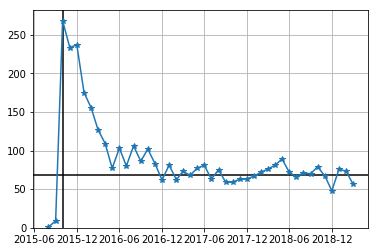

In [114]:
plt.plot(ts_musc_ra.index.values, ts_musc_ra.values, '*-')
plt.ylim(0)
ylims = plt.ylim()
xlims = plt.xlim()
plt.vlines(datetime.datetime(2015,10,1), ylims[0], ylims[1])
plt.hlines(ts_musc_ra.loc[[idx for idx in ts_musc_ra.index if idx>datetime.datetime(2017,6,1)]].mean(),
           xlims[0], xlims[1])
plt.grid()
plt.ylim(ylims)
plt.xlim(xlims)

68.85714285714286

(0.0, 395.8)

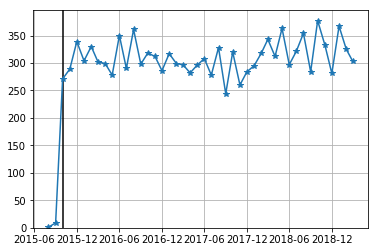

In [56]:
ts_musc_ra_2 = df_pat_states[(df_pat_states.inst=='MUSC')&(df_pat_states.disease_type=='RA')].groupby(['enc_month']).patient_id.nunique()

plt.plot(ts_musc_ra_2.index.values, ts_musc_ra_2.values, '*-')
plt.ylim(0)
ylims = plt.ylim()
plt.vlines(datetime.datetime(2015,10,1), ylims[0], ylims[1])
plt.grid()
plt.ylim(ylims)

In [63]:
df_pat_states['yr'] = df_pat_states.enc_month.apply(lambda dt: dt.year)

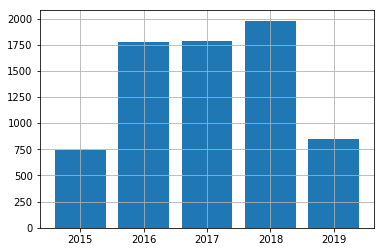

In [70]:
ts_musc_ra_3 = df_pat_states[(df_pat_states.inst=='MUSC')&(df_pat_states.disease_type=='RA')].groupby(['yr']).patient_id.nunique()

plt.bar(ts_musc_ra_3.index.values, ts_musc_ra_3.values)
plt.grid()

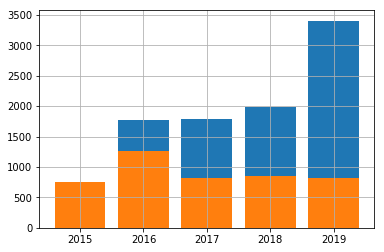

In [109]:
ts_musc_ra_4 = df_pat_states_r[(df_pat_states_r.inst=='MUSC')&(df_pat_states_r.disease_type=='RA')].groupby(['yr']).patient_id.nunique()

plt.bar(ts_musc_ra_3.index.values, ts_musc_ra_3.values[0:4].tolist() + [ts_musc_ra_3.values[4]*4])
plt.bar(ts_musc_ra_4.index.values, ts_musc_ra_4.values[0:4].tolist() + [ts_musc_ra_4.values[4]*4])
plt.grid()

In [115]:
69*12

828